# Optical character recognition


## Introduction
Optical character recognition is the electronic conversion of images of typed, handwritten or printed text into machine-encoded text, such as from a scanned document, a photo of a document.

In this tutorial, we will go over how to use forte help us manage/process data related to OCR task. We first need to read image containing text from data source and then process it to obtain text. Therefore, we need a reader and a processor in the pipeline. Plus, we also expect that for each character we can locate a bounding box in the original image. Therefore, we use the ontology `forte.data.ontology.top.Link` that links `forte.data.ontology.top.Annotation` and `forte.data.ontology.top.Box`.

## Installation
User needs to install `pytesseract` all its dependencies from [here](https://github.com/madmaze/pytesseract#installation)

## Pipeline Components for OCR
### OCR Reader

It's essentially a reader that reads image from an url, and load the image into `ImagePayload` in the DataPack.

In [1]:
from forte.data.base_reader import PackReader
from ft.onto.base_ontology import ImagePayload
from PIL import Image
import requests
from forte.data.data_pack import DataPack
from typing import Iterator, Any

class OcrReader(PackReader):
    r"""
    :class:`OcrReader` is designed to read an image for an OCR task.
    """
    def _collect(self, image_path) -> Iterator[Any]:  # type: ignore
        r"""
        Should be called with param `image_path` which is the path
        of the image file.

        Args:
            image_path: Image path.

        Returns: Iterator over paths to Image files
        """
        return image_path

    def _parse_pack(self, data_source: str) -> Iterator[DataPack]:
        r"""
        Takes a data source uri and read data from it into :class:`~forte.data.data_pack.DataPack`.

        Args:
            data_source: uri of the image for OCR task.

        Returns: :class:`~forte.data.data_pack.DataPack` containing ImagePayload.
        """
        pack: DataPack = DataPack()
        payload_idx = 0
        
        # Read in Image data and store in DataPack
        # add Image payload into DataPack.payloads
        image_data = Image.open(requests.get(data_source, stream=True).raw)
        width, height = image_data.size
        ip.set_cache(image_data, [height, width])
        yield pack

/home/murphy/anaconda3/envs/forte_org_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## OCR Processor
It analyzes the image in the DataPack ImagePayload, and predict the bounding box for each character. It wraps predicted bounding boxes and characters in forte ontology and write back into the DataPack.

In [2]:
from forte.data.ontology.top import Box, Link
from ft.onto.base_ontology import Character, Document

from forte.processors.base.pack_processor import PackProcessor
import pytesseract

class OcrCharacterProcessor(PackProcessor):
    """
    A character processor that recognizes characters in an image using pytesseract.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)

    def _process(self, input_pack: DataPack):
        image_data = input_pack.image_payloads[0].cache
        ocr_text = pytesseract.image_to_string(image_data)
        input_pack.set_text(ocr_text)
        # recognize bounding boxes of text using tesseract
        boxes = pytesseract.image_to_boxes(image_data)
        # boxes are in the format of strings
        # each line of strings represents a configuration of one bounding box
        # each line is in the format of "character, x0, y0, x1, y1" and the origin is at the bottom-left corner
        boxes = boxes.strip().split("\n")
        begin = 0
        image_height = image_data.height
        # iterate over each line of boxes and add the corresponding 
        # Character annotation into the data pack
        for b in boxes:
            b = b.split(" ")
            ch = b[0]
            # pytesseract returns the bounding box whose origin is at the bottom-left
            # so we need to convert the origin to the top-left by using the height of the image and swap y1 and y0
            x0, y1, x1, y0 = int(b[1]), image_height- int(b[2]), int(b[3]), image_height- int(b[4])
            # skip empty text
            while ocr_text[begin].isspace():
                begin += 1
            # for each recognized text, create a box, a character, and a link associating the box and the character
            if ocr_text[begin] == ch:
                character = Character(input_pack, begin, begin+1)
                box = Box(input_pack, [y0, x0], [y1, x1])
                Link(input_pack, character, box)
            else:
                raise ValueError(f"text {ocr_text[begin]} != {ch}")
            begin += 1

In [3]:
from ft.onto.base_ontology import Token
class OcrTokenProcessor(PackProcessor):
    """
    A token processor that recognizes tokens in an image using pytesseract.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)

    def _process(self, input_pack: DataPack):

        image_data = input_pack.image_payloads[0].cache
        for token in input_pack.get(Token):
            if len(token.text) >= 1:
                charcters = list(token.get(Character))
                # obtain the bounding box of the first and last character of a token
                # so that we can locate the bounding box for the token
                first_ch_link = input_pack.get_links_by_parent(charcters[0])[0]
                last_ch_link =  input_pack.get_links_by_parent(charcters[-1])[0]
                first_ch_bb = first_ch_link.get_child() 
                last_ch_bb = last_ch_link.get_child()
                top_left = [first_ch_bb.box_min_y, first_ch_bb.box_min_x]
                bottom_right = [last_ch_bb.box_max_y, last_ch_bb.box_max_x]
                # similar to adding characters in OCRProcessor
                # we add token bounding box, token and their link to the data pack
                token_box = Box(input_pack, top_left, bottom_right)
                Link(input_pack, token, token_box)

Let's first take a look at the image we are going to analyze, and it's a common cellphone messaging interface and contains text such as date and text body.

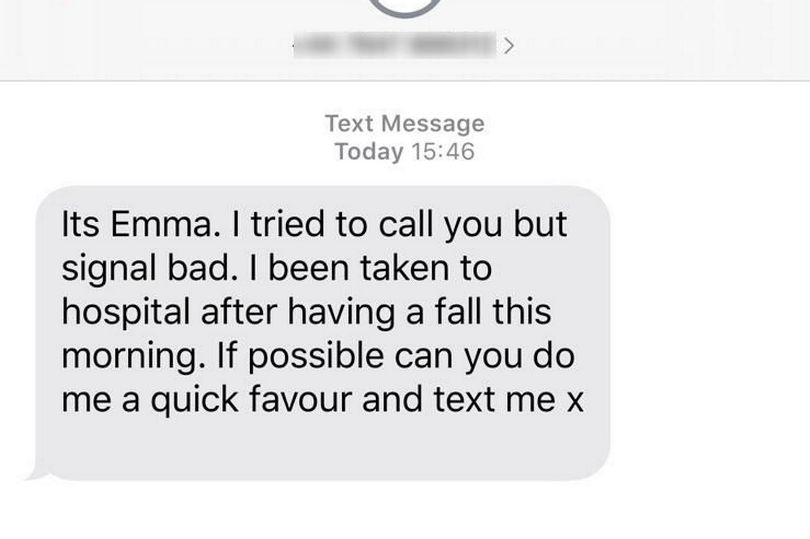

In [4]:
import IPython
image_url = 'https://raw.githubusercontent.com/asyml/forte/assets/ocr_tutorial/ocr.jpg'
IPython.display.Image(image_url, width = 250)

Let's set up a forte pipeline for the OCR task. As the processing order is same as adding order. We have the following pipeline
1. `OcrCharacterProcessor` recognizes bounding boxes for characters, and the complete text in the image.
2. `NLTKWordTokenizer` tokenizes the complete text into tokens.
3. `OcrTokenProcessor` recognizes bounding boxes for tokens.

Therefore, we have the following code to set up pipeline and process one image from an url data source.

In [5]:
from forte.pipeline import Pipeline
from fortex.nltk import NLTKWordTokenizer

pipeline = Pipeline[DataPack]()
pipeline.set_reader(
    OcrReader()
)
pipeline.add(OcrCharacterProcessor())
pipeline.add(NLTKWordTokenizer())
pipeline.add(OcrTokenProcessor())
pipeline.initialize()
pack = pipeline.process_one([image_url])


User can repetitively run this code cell below to recognize all the bounding boxes for the input character

Input character:  k
Recognized Bounding Box surrounding k


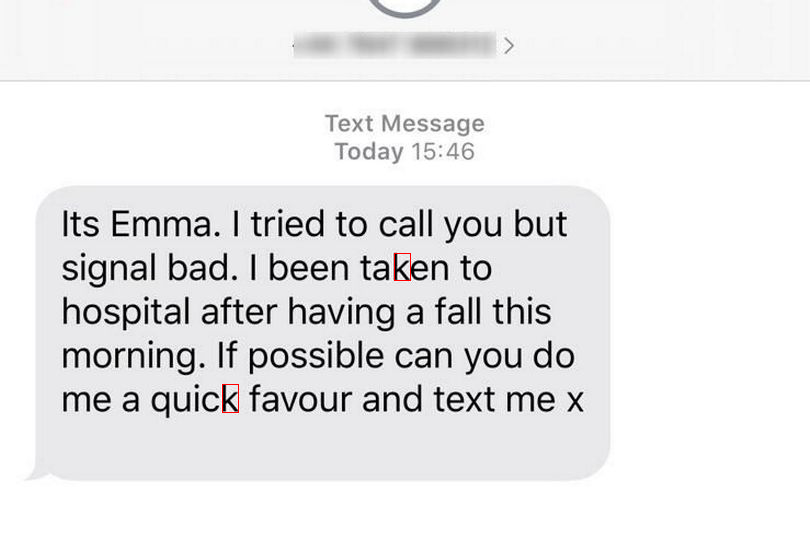

In [6]:
from PIL import Image, ImageDraw
charcters = list(pack.get(Character))
character_text = [ch.text for ch in charcters]
input_ch = ""

# check whether the input character is valid
while len(input_ch) != 1:
    input_ch = input("Enter the character you want to visualize: ")
    if len(input_ch) != 1:
        print("Please input a single character.")
    elif input_ch not in [c.text for c in charcters]:
        print(f"Character not found. Please input a single character from the text below: \n {pack.text}")
        input_ch = ""

# a function that iterates over all the characters in the text and returns the index of the character
def find(ch_list, char):
    for i, c in enumerate(ch_list):
        if c == char:
            yield i

image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)
for ch_index in find(character_text, input_ch):
    link = pack.get_links_by_parent(charcters[ch_index])[0]
    ch = link.get_parent()
    ch_bb= link.get_child()
    
    d.rectangle([(ch_bb.box_min_x, ch_bb.box_min_y), (ch_bb.box_max_x, ch_bb.box_max_y)], outline = "#ff0000")
print("Input character: ", ch.text)
print(f"Recognized Bounding Box surrounding {ch.text}")
image_data

User to can run the code cell below to recognize the bounding boxes for all characters.
It obtain the bounding box from the character and its link.

Recognized characters: 
 ['T', 'e', 'x', 't', 'M', 'e', 's', 's', 'a', 'g', 'e', 'T', 'o', 'd', 'a', 'y', '1', '5', ':', '4', '6', 'I', 't', 's', 'E', 'm', 'm', 'a', '.', '|', 't', 'r', 'i', 'e', 'd', 't', 'o', 'c', 'a', 'l', 'l', 'y', 'o', 'u', 'b', 'u', 't', 's', 'i', 'g', 'n', 'a', 'l', 'b', 'a', 'd', '.', '|', 'b', 'e', 'e', 'n', 't', 'a', 'k', 'e', 'n', 't', 'o', 'h', 'o', 's', 'p', 'i', 't', 'a', 'l', 'a', 'f', 't', 'e', 'r', 'h', 'a', 'v', 'i', 'n', 'g', 'a', 'f', 'a', 'l', 'l', 't', 'h', 'i', 's', 'm', 'o', 'r', 'n', 'i', 'n', 'g', '.', 'I', 'f', 'p', 'o', 's', 's', 'i', 'b', 'l', 'e', 'c', 'a', 'n', 'y', 'o', 'u', 'd', 'o', 'm', 'e', 'a', 'q', 'u', 'i', 'c', 'k', 'f', 'a', 'v', 'o', 'u', 'r', 'a', 'n', 'd', 't', 'e', 'x', 't', 'm', 'e', 'x']


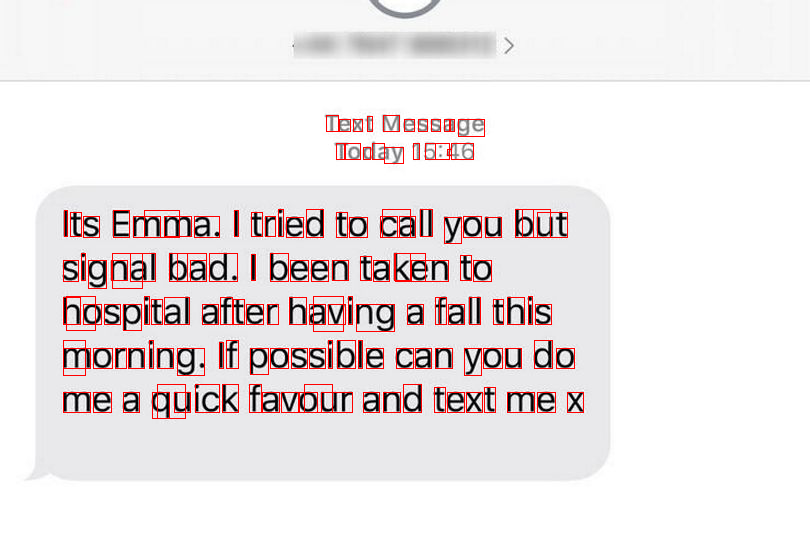

In [7]:
image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)
for ch in pack.get(Character):
    ch_link = pack.get_links_by_parent(ch)[0]
    ch_bb = ch_link.get_child()
    d.rectangle([(ch_bb.box_min_x, ch_bb.box_min_y), (ch_bb.box_max_x, ch_bb.box_max_y)], outline = "#ff0000")
print("Recognized characters: \n", [ch.text for ch in pack.get(Character)])
image_data

User to can run the code cell below to recognize the bounding boxes for all tokens.

Recognized tokens: 
 ['Text', 'Message', 'Today', '15:46', 'Its', 'Emma.', '|', 'tried', 'to', 'call', 'you', 'but', 'signal', 'bad.', '|', 'been', 'taken', 'to', 'hospital', 'after', 'having', 'a', 'fall', 'this', 'morning.', 'If', 'possible', 'can', 'you', 'do', 'me', 'a', 'quick', 'favour', 'and', 'text', 'me', 'x']


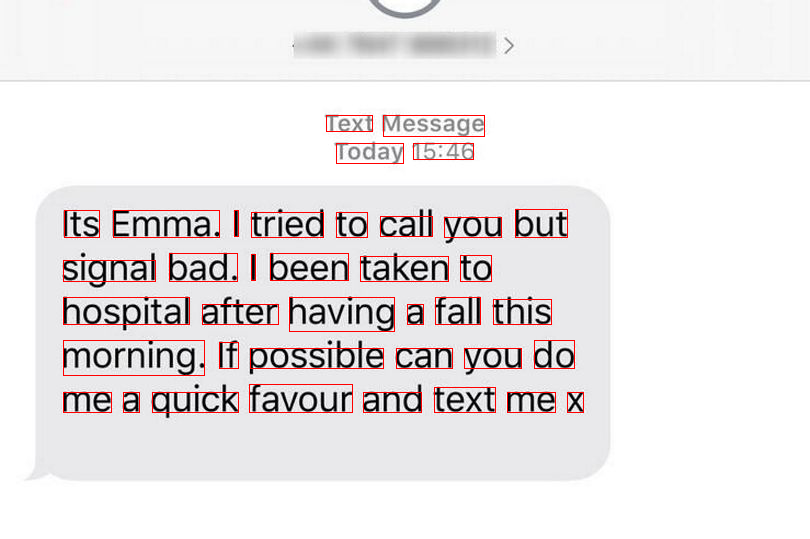

In [8]:
image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)
for token in pack.get(Token):
    token_link = pack.get_links_by_parent(token)[0]
    token_bb = token_link.get_child()
    d.rectangle([(token_bb.box_min_x, token_bb.box_min_y), (token_bb.box_max_x, token_bb.box_max_y)], outline = "#ff0000") # visualize the bounding box
print("Recognized tokens: \n", [tk.text for tk in pack.get(Token)])
image_data

One can also add a `OcrSentenceProcessor` and `NLTKSentenceSegmenter` to create bounding boxes for sentences just as the paired NLP components, `NLTKWordTokenizer` and `OcrTokenProcessor`.